# Контроль качества данных

DQ (Data Quality, качество данных) - характеристика данных, показывающая степень их пригодности к анализу. Оценка качества данных – необходимый шаг любого проекта создания DWH.

Доверие к данным – краеугольный камень любого DWH.
(с) Ральф Кимбалл

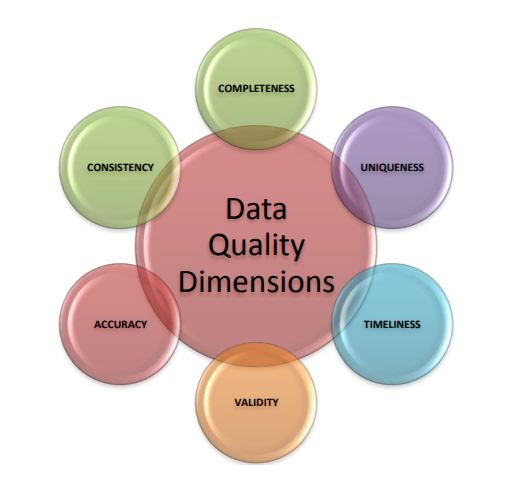

Критерии качества данных:
    
    • Своевременность
    • Согласованность
    • Точность
    • Полнота
    • Интерпретируемость
    • Уникальность

Своевременность - этот критерий выражает требование к регулярности загрузки данных в хранилище. Если требованиями определенно, что данные загружаются ежедневно, то данные отстающие на один день будут считаться не качественными.

Согласованность - этот критерий выражает требование к непротиворечивости данных, то есть данные не должны противоречить друг другу. Поскольку, зачастую, в хранилищах лежат рельные данные несогласованными будут являться, например две одинаковых записи о выполнении заказа с разными суммами оплаты. Такие ошибки зачастую связанны, либо с неправильным алгоритмом разложения исходной таблицы в модель данных, либо с некачественныи источником.

Точность (семантическая точность) - определяется как соответствие заданного значения реальному. Данный критерий применяется к количественным полям, может быть расчитан как среднеквадратичное отклонение по заданному полю за определенный промежуток времени. Либо другими статистическими методами для поиска выбросов. Данный критерий требует глубокого погружения в предметную область, чтобы понять являются ли выбросы в значениях сбоем в системе, либо же аномальными показателями.

Полнота - определяется как отношение количества непустых значений к общему количеству записей. Также полноту можно определить, как среднеквадратичное отклонение количества всех записей за определенный промежуток времени.

Интерпретируемость (синтаксическая точность) - этот критерий определяет совпадение значения атрибута со значением, принадлежащим предметной области. Другими словами, проверка на допустимость символом и/или соответсвие шаблону. Например, формат хранения номеров телефона. В разных источниках он хранится по разному (с тире, с плюсом, со скобками). Данные будут являться качественными, если мы приведем их все к единому формату.

Уникальность - определяется как отсутсвие дубликатов.

Инциденты DQ с точки зрения загрузки:

    • Критические – сбои в работе ETL процессов (ничего не загрузилось);
    • Не критические – сбои в данных, которые иногда не так просто отследить;

Модули проверки качества данных рассматривют не критические сбои в данных, посокльку функионал оповещений о критических инцедентах можно легко реализовать на уровне оркестраторов (пример: в аирфлоу параметр дага "email_on_failure": True)

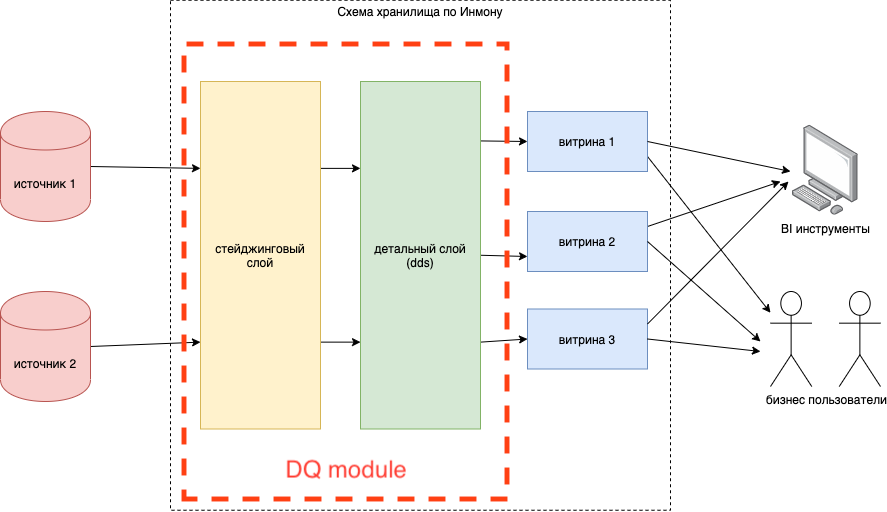

Я выделил Data quality в отдельный модуль, так как хорошей практикой будет не включать его в etl пайплайн. Это должна быть отдельная система проверок и поповещений (отдельный даг), которая никак не затрагивает основной пайплайн.

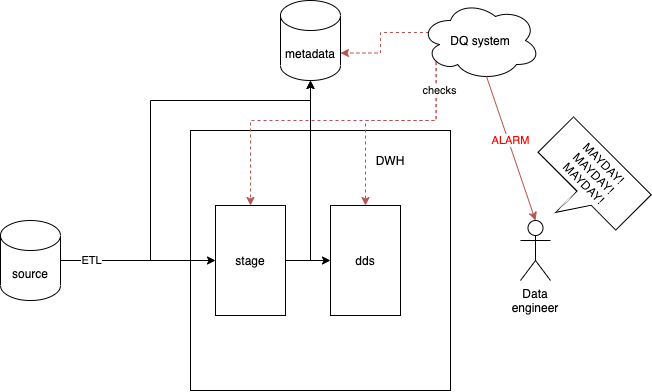

# Метаданные

Для эффективного контроля за etl процессами, нам понадобится хранить метаданные о них.

Хорошей практикой будет хранение метаданных и логов в СУБД отличной от той, где находится хранилище. Это позволит изолировать их друг от друга. И при поломке одного компонента не будут затронуты остальные.

Для нашего удобвства создадим таблицу с логами в целевом постгресе:

In [6]:
import psycopg2

q = """
create table log (
       source_launch_id    int
     , target_schema       text
     , target_table        text  
     , target_launch_id    int
     , processed_dttm      timestamp default now()
     , row_count           int
     , duration            interval
     , load_date           date
)
"""


conn_string= "host='localhost' port=5433 dbname='my_database2' user='admin' password='postgres'" 
with psycopg2.connect(conn_string) as conn, conn.cursor() as cursor:
    cursor.execute(q)


Комментарии по полям:
    
    • source_launch_id, target_launch_id - нужны для отслеживания изменения уникальных идентфификаторов тасков
    • target_schema, target_table - с какой схемой, таблицей работаем
    • processed_dttm - время записи лога
    • row_count - сколько строк заинсертилось
    • duration - продолжительность таска
    • load_date - дата загрузки (не всегда равно processed_dttm, так как можем перезапускать таски из прошлого)

Также создадим таблицу для сбора статистики:

In [8]:
import psycopg2

q = """
create table statistic (
       table_name     text
     , column_name    text
     , cnt_nulls      int
     , cnt_all        int
     , load_date      date
)
"""

conn_string= "host='localhost' port=5433 dbname='my_database2' user='admin' password='postgres'" 
with psycopg2.connect(conn_string) as conn, conn.cursor() as cursor:
    cursor.execute(q)

Комментарии по полям:
    
    • table_name, column_name - имя таблицы, колонки
    • cnt_nulls - количество наллов в колонке
    • cnt_all - количество строк в колонке
    • load_date - дата загрузки

Дополнительные поля в нашем хранилище (у всех таблиц):
    
    • launch_id (уникальный идентификатор таска)
    • effective_dttm (дата загрузки, default now())

Создадим файл utils.py, в котором будут хранится различные методы для сбора статистики, записи логов и проверки статуса загрузки данных:

In [ ]:
import psycopg2
import logging
from airflow.models import BaseOperator

class DataFlowBaseOperator(BaseOperator):
    def __init__(self, pg_meta_conn_str, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.pg_meta_conn_str = pg_meta_conn_str

    def write_etl_log(self, config):
        with psycopg2.connect(self.pg_meta_conn_str) as conn, conn.cursor() as cursor:
            query = '''
            insert into log (
                   source_launch_id
                 , target_schema
                 , target_table
                 , target_launch_id
                 , row_count
                 , duration
                 , load_date
            )
            select {launch_id}
                , '{target_schema}'
                , '{target_table}'
                , {job_id}
                , {row_count}
                , '{duration}'
                , '{dt}'
            '''
            cursor.execute(query.format(**config))
            logging.info('Log update: {target_table} : {job_id}'.format(**config))
            conn.commit()


    def write_etl_statistic(self, config):
        with psycopg2.connect(self.pg_meta_conn_str) as conn, conn.cursor() as cursor:
            query = '''
            insert into statistic (
                   table_name
                 , column_name
                 , cnt_nulls
                 , cnt_all
                 , load_date
            )
            with x as (
                select '{table}' as table_name
                     , '{column}' as column_name
                     , {cnt_nulls} as cnt_nulls
                     , {cnt_all} as cnt_all
                     , {launch_id} as launch_id
            )
            select table_name
                 , column_name
                 , cnt_nulls
                 , cnt_all
                 , load_date
              from x left join log l
                on x.launch_id = l.target_launch_id
            '''
            cursor.execute(query.format(**config))
            conn.commit()


    def get_load_dates(self, config):
        with psycopg2.connect(self.pg_meta_conn_str) as conn, conn.cursor() as cursor:
            query = '''
            select array_agg(distinct load_date order by load_date)
                from log
                where target_table = '{target_table}'
                and target_schema = '{target_schema}'
                and source_launch_id = -1
            '''
            cursor.execute(query.format(**config))
            dates = cursor.fetchone()[0]
        if dates:
            return dates
        else:
            return []


Модифицируем код data_transfer.py, добавив методы записи логов и проверку загрузки за определенную дату:

In [ ]:
import logging
import os
import time
import psycopg2
from contextlib import contextmanager
from airflow.models import BaseOperator
from airflow.utils.decorators import apply_defaults
from operators.utils import DataFlowBaseOperator


class DataTransfer(DataFlowBaseOperator): # modify
    @apply_defaults
    def __init__(self, config, pg_conn_str, pg_meta_conn_str, date_check=False, *args, **kwargs):
        super(DataTransfer, self).__init__(
            *args,
            **kwargs
        )
        self.config = config
        self.pg_conn_str = pg_conn_str
        self.pg_meta_conn_str = pg_meta_conn_str
        self.date_check = date_check

    def provide_data(self, csv_file, context):
        pass

    def execute(self, context):
        copy_statement = """
        COPY {target_schema}.{target_table} ({columns}, launch_id as {job_id}) FROM STDIN with
        DELIMITER '\t'
        CSV
        ESCAPE '\\'
        NULL '';
        """
        schema_name = "{table}".format(**self.config).split(".")
        self.config.update( 
            target_schema=schema_name[0],
            target_table=schema_name[1],
            job_id=context["task_instance"].job_id, # modify
            dt=context["task_instance"].execution_date, # modify
        )
        # modify
        if self.date_check and context["execution_date"] in self.get_load_dates(
            self.config
        ):
            logging.info("Data already load")
            return
        with psycopg2.connect(self.pg_conn_str) as conn, conn.cursor() as cursor:
            start = time.time() # modify
            # modify
            cursor.execute(
                """
            select column_name
              from information_schema.columns
             where table_schema = '{target_schema}'
               and table_name = '{target_table}'
               and column_name not in ('launch_id', 'effective_dttm');
            """.format(
                    **self.config
                )
            )
            result = cursor.fetchall()
            columns = ", ".join('"{}"'.format(row) for row, in result)
            self.config.update(columns=columns)

            with open("transfer.csv", "w", encoding="utf-8") as csv_file:
                self.provide_data(csv_file, context)

            self.log.info("writing succed")

            with open('transfer.csv', 'r', encoding="utf-8") as f:
                cursor.copy_expert(copy_statement.format(**self.config), f)

            self.config.update( # modify
                launch_id=-1,
                duration=datetime.timedelta(seconds=time.time() - start),
                row_count=cursor.rowcount
            )
            self.write_etl_log(self.config) # modify
            

Код дага тоже модифицируем, так как мы добавили новый атрибут класса "pg_meta_conn_str":

In [ ]:
from airflow import DAG
from operators.postgres import DataTransferPostgres
from datetime import datetime


DEFAULT_ARGS = {
    "owner": "airflow",
    "start_date": datetime(2021, 1, 25),
    "retries": 1,
    "email_on_failure": False,
    "email_on_retry": False,
    "depends_on_past": True,
}

with DAG(
    dag_id="pg-data-flow",
    default_args=DEFAULT_ARGS,
    schedule_interval="@daily",
    max_active_runs=1,
    tags=['data-flow'],
) as dag1:
    t1 = DataTransferPostgres(
        config={'table': 'public.customer'},
        query='select * from customer'
        task_id='customer',
        source_pg_conn_str="host='db2' port=5432 dbname='tpch' user='postgres' password='postgres'",
        pg_conn_str="host='db1' port=5432 dbname='my_database2' user='admin' password='postgres'",
        pg_meta_conn_str="host='db1' port=5432 dbname='my_database2' user='admin' password='postgres'", # modify
    )

Подведем итоги:

    • познакомились с понятием Data quality и метаданные
    • узнали какие есть метрики и методы для оценки качества данных
    • реализовали оператор для записи логов, сбора статистики и проверки загрузки данных
    • модифицировали код базового оператора, теперь он пишет лог и делает проверку были ли загружены данные

Источники:

    • https://www.psycopg.org/docs/cursor.html
    • http://www.scielo.br/scielo.php?script=sci_arttext&pid=S1807-17752020000100303
    • https://www.edq.com/glossary/data-quality/

## Домашнее задание

1) Написать оператор для сбора статистики в таблицу statistic. Метод записи из utils.py: def write_etl_statistic().
<br>2) Создать отдельный даг с этим оператором. Перед сбором статистики должен быть external_task_sensor на успешное выполнение переливки данных. Документация по сенсору: https://airflow.apache.org/docs/apache-airflow/1.10.4/_api/airflow/sensors/external_task_sensor/index.html